# Valuation Project (Project 1)

## Chenyu Wang & Zian zhang

### Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, leastsq
from scipy.stats import norm

### Part 1 : Calibrate the 5 parameters

#### Step 1 : Write 2 classes to prepare for the optimization problem

In [2]:
class Option:
    def __init__(self, miu_1, miu_2, sigma_1, sigma_2, u, r, T):
        self.miu_1 = miu_1
        self.miu_2 = miu_2
        self.sigma_1 = sigma_1
        self.sigma_2 = sigma_2
        self.u = u
        self.r = r
        self.T = T
    
    def option_price(self, miu, sigma, k):
        d1 = (np.log(miu*np.exp(-self.r*self.T)/k)+(0.5*pow(sigma,2))*self.T)/(sigma*np.sqrt(self.T))
        d2 = d1 - sigma*np.sqrt(self.T)
        N_d1 = norm.cdf(d1)
        N_d2 = norm.cdf(d2)
        return (miu*np.exp(-self.r*self.T))*N_d1 - k*np.exp(-self.r*self.T)*N_d2
    
    def theoritical_price(self, k):
        option_1 = self.option_price(self.miu_1, self.sigma_1, k) 
        option_2 = self.option_price(self.miu_2, self.sigma_2, k) 
        return self.u*option_1 + (1-self.u)*option_2
    
    def deriv_k(self, miu, sigma, k):
        d1 = (np.log(miu*np.exp(-self.r*self.T)/k)+(0.5*pow(sigma,2))*self.T)/(sigma*np.sqrt(self.T))
        d2 = d1 - sigma*np.sqrt(self.T)
        return 1/(k*sigma*np.sqrt(2*np.pi*self.T))*np.exp(-self.r*self.T - 0.5*pow(d2, 2))
    
    def deriv_the_k(self, k):
        deriv_k_1 = self.deriv_k(self.miu_1, self.sigma_1, k)
        deriv_k_2 = self.deriv_k(self.miu_2, self.sigma_2, k)
        return self.u*deriv_k_1 + (1 - self.u)*deriv_k_2
    
    def update_params(self, x):
        self.miu_1 = x[0]
        self.miu_2 = x[1]
        self.sigma_1 = x[2]
        self.sigma_2 = x[3]
        self.u = x[4]       

In [3]:
class Fitter:
    def __init__(self, model, k_data, true_value):
        self.model = model
        self.k_data = k_data
        self.true_value = true_value
    
    def residuals(self,x):
        m = self.model
        m.update_params(x)
        thr_value = np.array([m.theoritical_price(k) for k in self.k_data])
        residual = thr_value - self.true_value
        return residual
    
    def fit(self,x0):
        bound_lower = [0, 0, 0, 0, 0]
        bound_upper = [4000, 4000, 0.5, 0.5, 1]
        return least_squares(self.residuals,x0, bounds = (bound_lower, bound_upper))

#### Step 2 : Import data

In [4]:
data = pd.read_excel('val_data.xlsx')

In [5]:
data.head()

,strike,type,price
0,1500,Call,1623.9
1,1600,Call,1524.8
2,1700,Call,1425.6
3,1800,Call,1326.6
4,1850,Call,1277.1


#### Step 3 : Initialize the 5 parameters

In [6]:
x0 = [2800, 3200, 0.1, 0.2, 0.5]
model1 = Option(2800, 3200, 0.1, 0.2, 0.5, 0.02, 0.5)

In [7]:
fitter = Fitter(model1, np.array(data['strike']), np.array(data['price']))

#### Step 4 : Optimization

In [8]:
fitter.fit(x0)

 active_mask: array([0, 0, 0, 0, 0])
        cost: 43.85517816624806
         fun: array([ 1.29198213,  1.38709177,  1.58287066,  1.58245991,  1.58688261,
        1.59847807,  1.52310692,  1.37015515,  1.15384676,  0.99463956,
        0.72053115,  0.36806101, -0.01721261, -0.20585631, -0.24880556,
       -0.38094935, -0.40176828, -0.51073346, -0.50730727, -0.59094419,
       -0.66109166, -0.71719096, -0.75867817, -0.78498515, -0.89554052,
       -0.88977074, -0.96710113, -0.92695698, -0.96876463, -0.9919526 ,
       -0.99595268, -0.98020111, -1.04413965, -0.98721671, -1.00888851,
       -1.0086201 , -0.98588653, -0.94017386, -0.8709802 , -0.87781674,
       -0.76020873, -0.71769641, -0.74983594, -0.65620024, -0.63637982,
       -0.48998358, -0.51663952, -0.41599539, -0.38771937, -0.3315006 ,
       -0.24704969, -0.13409918, -0.09240391, -0.0217413 ,  0.07808839,
        0.107262  ,  0.16593346,  0.25423394,  0.37227224,  0.42013531,
        0.49788924,  0.60558042,  0.64323739,  0.7108

In [9]:
x_final = fitter.fit(x0).x

#### Step 5 : Print the result of the optimization

In [10]:
x_final

array([2.83276418e+03, 3.25942141e+03, 1.85769664e-01, 6.00749496e-02,
       2.76324822e-01])

#### Step 6 : Examine the result of the optimization

In [11]:
Option_final = Option(x_final[0], x_final[1], x_final[2], x_final[3], x_final[4], 0.02, 0.5)

In [12]:
price_list = []
for k in np.array(data['strike']):
    price_list.append(Option_final.theoritical_price(k))

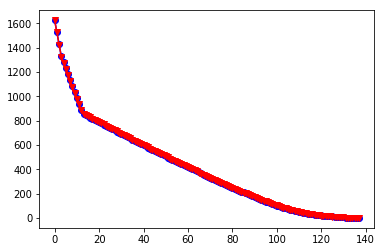

In [13]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, len(price_list), 1), price_list, marker = 'o', color = 'b')
ax.plot(np.arange(0, len(price_list), 1), np.array(data['price']), marker = 'v', color = 'r')
plt.show()

### Part 2 : Draw the implied distribution graph

#### Method 1 : Numerical method

In [14]:
def compute_pdf(x, k):
    opt = Option(x[0], x[1], x[2], x[3], x[4], 0.02, 0.5)
    thre_value = opt.theoritical_price(k)
    thre_value_1 = opt.theoritical_price(k + 0.01)
    thre_value_2 = opt.theoritical_price(k - 0.01)
    return (thre_value_1 + thre_value_2 - 2*thre_value)/(0.01*0.01)

In [15]:
pdf_list = []
for i in np.arange(1500, 4000, 10):
    pdf_list.append(compute_pdf(x_final, i))

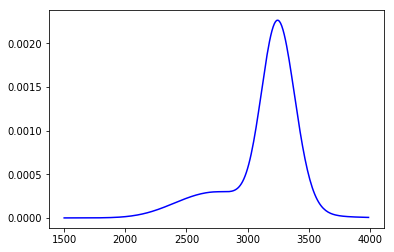

In [16]:
fig, ax = plt.subplots()
ax.plot(np.arange(1500, 4000, 10), pdf_list, color = 'b')
plt.show()

#### Method 2 : Analytical method

In [17]:
pdf_list_2 = []
for i in range(1500, 4000, 10):
    pdf_list_2.append(Option_final.deriv_the_k(i))

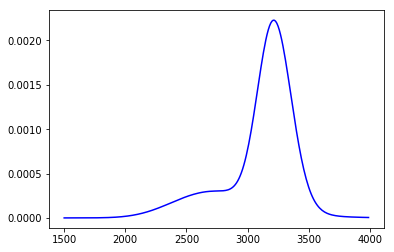

In [18]:
fig, ax = plt.subplots()
ax.plot(np.arange(1500, 4000, 10), pdf_list_2, color = 'b')
plt.show()

### Part 3 : Implied Volatility

#### Step 1 : BS formula

In [19]:
def BS(r, T, S0, sigma, K):
    d1 = (np.log(S0/K) + 0.5*pow(sigma, 2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    return S0*N_d1 - K*np.exp(-r*T)*N_d2

#### Step 2 : Find the implied volatility

In [20]:
def find_root(r, T, S0, K, true_value):
    a = 0.00001
    b = 1
    diff_1 = true_value - BS(r, T, S0, a, K)
    diff_2 = true_value - BS(r, T, S0, b, K)
    while abs(diff_1) > 10e-7:
        diff = true_value - BS(r, T, S0, (a+b)/2, K)
        if diff*diff_1 > 0:
            a = (a+b)/2
        else :
            b = (a+b)/2
        diff_1 = true_value - BS(r, T, S0, a, K)
        diff_2 = true_value - BS(r, T, S0, b, K)
        
    return (a+b)/2 

#### Step 3 : draw the implied volatility graph

In [21]:
implied_vol = []
for i in range(data.shape[0]):
    implied_vol.append(find_root(0.02, 0.5, 3100, data.iloc[i, 0],data.iloc[i, 2]))

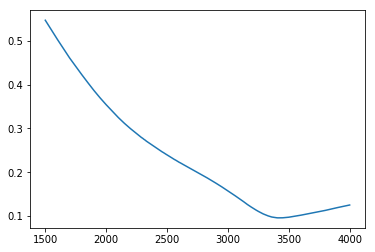

In [22]:
plt.plot(np.array(data['strike']), np.array(implied_vol))
plt.show()